In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense
from keras.layers import Activation
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score, accuracy_score

# Data Pre-processing

In [2]:
# Read csv
df = pd.read_csv("../compiled.csv")

# Remove 5-tuple
new_df = df.iloc[:, 5:].copy()

# Replace "inf" with numpy.nan
new_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop columns containing numpy.nan
new_df = new_df.dropna()

# Dataset Info
print(new_df.shape)
print(new_df['Label'].value_counts())
#print(df.info())
#print(df['Label'].describe())

(18697, 24)
Label
3    5611
5    5244
1    5071
2    1847
4     711
0     213
Name: count, dtype: int64


# Over Sampling (Resample)

In [3]:
# Separate the instances of each class into different dataframes
df_class_0 = new_df[new_df['Label'] == 0]
df_class_1 = new_df[new_df['Label'] == 1]
df_class_2 = new_df[new_df['Label'] == 2]
df_class_3 = new_df[new_df['Label'] == 3]
df_class_4 = new_df[new_df['Label'] == 4]
df_class_5 = new_df[new_df['Label'] == 5]

# Identify the class with the largest number of instances
max_size = max(df_class_0.shape[0], df_class_1.shape[0], df_class_2.shape[0], df_class_3.shape[0], df_class_4.shape[0], df_class_5.shape[0])

# Resample the dataframes for the minority classes
df_class_0_resampled = resample(df_class_0, replace=True, n_samples=max_size, random_state=123)
df_class_2_resampled = resample(df_class_2, replace=True, n_samples=max_size, random_state=123)
df_class_4_resampled = resample(df_class_4, replace=True, n_samples=max_size, random_state=123)

# Combine the resampled dataframes back together
df_resampled = pd.concat([df_class_0_resampled, df_class_1, df_class_2_resampled, df_class_3, df_class_4_resampled, df_class_5])

df_resampled['Label'].value_counts()

# Normalise values
x = df_resampled.iloc[:,:-1].copy()
min_max_scaler = preprocessing.MinMaxScaler()
x = min_max_scaler.fit_transform(x)
y = df_resampled["Label"]

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=32)

# Reshape
X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
y_train_cnn= to_categorical(y_train)
y_test_cnn = to_categorical(y_test)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(y.value_counts())

(22931, 23)
(22931,)
(9828, 23)
(9828,)
Label
0    5611
2    5611
3    5611
4    5611
5    5244
1    5071
Name: count, dtype: int64


In [4]:
# Confusion matrix 
def plot_cm(y_test, y_pred):
    cm = confusion_matrix(y_pred, y_test)

    fig, ax = plt.subplots(figsize=(7.5, 7.5))
    ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center', size='xx-large')

    # Plot confusion matrix
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(6)
    plt.xticks(tick_marks, label_dict.values())
    plt.yticks(tick_marks, label_dict.values())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
# Dictionary to store results
results_dictionary = {}

# Labels Dictionary
label_dict = {
    0: "Chat",
    1: "Email",
    2: "File Transfer",
    3: "Streaming",
    4: "VoIP",
    5: "Gaming"
}

# Model Training

In [5]:
# Create the CNN Model
model = Sequential()

# 1st Convolutional Layer
model.add(Conv1D(128, 3, input_shape=(X_train.shape[1], 1), strides=1, activation = 'relu'))
# 2nd Convolution Layer
model.add(Conv1D(filters=128, kernel_size=3, strides=1, activation = 'relu'))
# Max Pooling and Dropout Layer
model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Dropout(0.25))

# 3rd Convolution Layer
model.add(Conv1D(filters=128, kernel_size=3, strides=1, activation = 'relu'))
# 4th Convolution Layer
model.add(Conv1D(filters=128, kernel_size=3, strides=1, activation = 'relu'))
#Max Pooling and Dropout Layer
model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Dropout(0.25))

# Fully Connected layer
model.add(Flatten())

# 1st Fully Connected Layer
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))

# Output Layer
model.add(Dense(y_test_cnn.shape[1], activation='softmax'))
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

model.fit(X_train_cnn, y_train_cnn, epochs = 200, validation_data = (X_test_cnn, y_test_cnn))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 21, 128)           512       
                                                                 
 conv1d_1 (Conv1D)           (None, 19, 128)           49280     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 9, 128)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 9, 128)            0         
                                                                 
 conv1d_2 (Conv1D)           (None, 7, 128)            49280     
                                                                 
 conv1d_3 (Conv1D)           (None, 5, 128)            49280     
                                                        

717/717 [==============================] - 7s 10ms/step - loss: 0.8183 - accuracy: 0.6922 - val_loss: 0.8173 - val_accuracy: 0.6931
Epoch 43/200
717/717 [==============================] - 7s 10ms/step - loss: 0.8148 - accuracy: 0.6950 - val_loss: 0.8094 - val_accuracy: 0.6991
Epoch 44/200
717/717 [==============================] - 11s 15ms/step - loss: 0.8140 - accuracy: 0.6963 - val_loss: 0.8429 - val_accuracy: 0.6879
Epoch 45/200
717/717 [==============================] - 10s 14ms/step - loss: 0.8089 - accuracy: 0.6953 - val_loss: 0.8018 - val_accuracy: 0.7016
Epoch 46/200
717/717 [==============================] - 7s 10ms/step - loss: 0.8089 - accuracy: 0.6966 - val_loss: 0.8042 - val_accuracy: 0.7077
Epoch 47/200
717/717 [==============================] - 10s 13ms/step - loss: 0.8058 - accuracy: 0.6977 - val_loss: 0.7952 - val_accuracy: 0.7065
Epoch 48/200
717/717 [==============================] - 11s 15ms/step - loss: 0.8069 - accuracy: 0.6996 - val_loss: 0.8019 - val_accuracy: 0

717/717 [==============================] - 9s 12ms/step - loss: 0.7518 - accuracy: 0.7174 - val_loss: 0.7878 - val_accuracy: 0.7174
Epoch 99/200
717/717 [==============================] - 9s 13ms/step - loss: 0.7630 - accuracy: 0.7166 - val_loss: 0.7670 - val_accuracy: 0.7303
Epoch 100/200
717/717 [==============================] - 10s 14ms/step - loss: 0.7492 - accuracy: 0.7192 - val_loss: 0.7918 - val_accuracy: 0.7088
Epoch 101/200
717/717 [==============================] - 9s 12ms/step - loss: 0.7527 - accuracy: 0.7178 - val_loss: 0.7715 - val_accuracy: 0.7228
Epoch 102/200
717/717 [==============================] - 10s 14ms/step - loss: 0.7451 - accuracy: 0.7193 - val_loss: 0.7776 - val_accuracy: 0.7215
Epoch 103/200
717/717 [==============================] - 9s 13ms/step - loss: 0.7482 - accuracy: 0.7185 - val_loss: 0.7888 - val_accuracy: 0.7035
Epoch 104/200
717/717 [==============================] - 9s 12ms/step - loss: 0.7488 - accuracy: 0.7181 - val_loss: 0.7893 - val_accuracy

Epoch 154/200
717/717 [==============================] - 12s 16ms/step - loss: 0.7219 - accuracy: 0.7294 - val_loss: 0.7649 - val_accuracy: 0.7289
Epoch 155/200
717/717 [==============================] - 9s 13ms/step - loss: 0.7245 - accuracy: 0.7285 - val_loss: 0.7569 - val_accuracy: 0.7309
Epoch 156/200
717/717 [==============================] - 9s 12ms/step - loss: 0.7268 - accuracy: 0.7247 - val_loss: 0.7816 - val_accuracy: 0.7158
Epoch 157/200
717/717 [==============================] - 10s 14ms/step - loss: 0.7192 - accuracy: 0.7281 - val_loss: 0.7503 - val_accuracy: 0.7296
Epoch 158/200
717/717 [==============================] - 12s 17ms/step - loss: 0.7221 - accuracy: 0.7298 - val_loss: 0.7587 - val_accuracy: 0.7271
Epoch 159/200
717/717 [==============================] - 10s 14ms/step - loss: 0.7140 - accuracy: 0.7324 - val_loss: 0.7658 - val_accuracy: 0.7266
Epoch 160/200
717/717 [==============================] - 11s 15ms/step - loss: 0.7234 - accuracy: 0.7266 - val_loss: 0.7

308/308 [==============================] - 1s 4ms/step


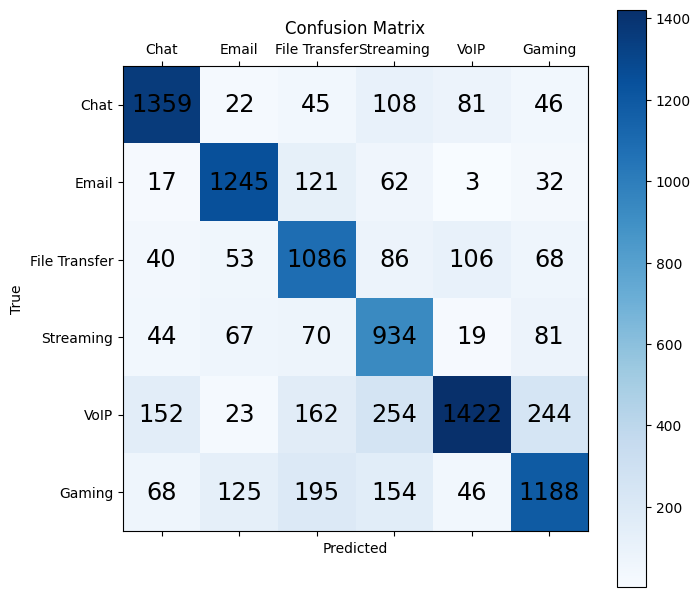

               precision    recall  f1-score   support

         Chat     0.8182    0.8089    0.8135      1680
        Email     0.8412    0.8111    0.8259      1535
File Transfer     0.7547    0.6468    0.6966      1679
    Streaming     0.7687    0.5845    0.6641      1598
         VoIP     0.6300    0.8479    0.7229      1677
       Gaming     0.6689    0.7161    0.6917      1659

     accuracy                         0.7361      9828
    macro avg     0.7470    0.7359    0.7358      9828
 weighted avg     0.7456    0.7361    0.7352      9828



In [6]:
y_pred = model.predict(X_test_cnn)
y_pred = np.argmax(y_pred, axis=1)

# Confusion matrix 
plot_cm(y_test, y_pred)

# Classification report
print(classification_report(y_test, y_pred, digits=4, target_names=label_dict.values()))

# Store Results
results_dictionary["CNN"] = [accuracy_score(y_test, y_pred), precision_score(y_test, y_pred, average="weighted"), recall_score(y_test, y_pred, average="weighted"), f1_score(y_test, y_pred, average="weighted")]

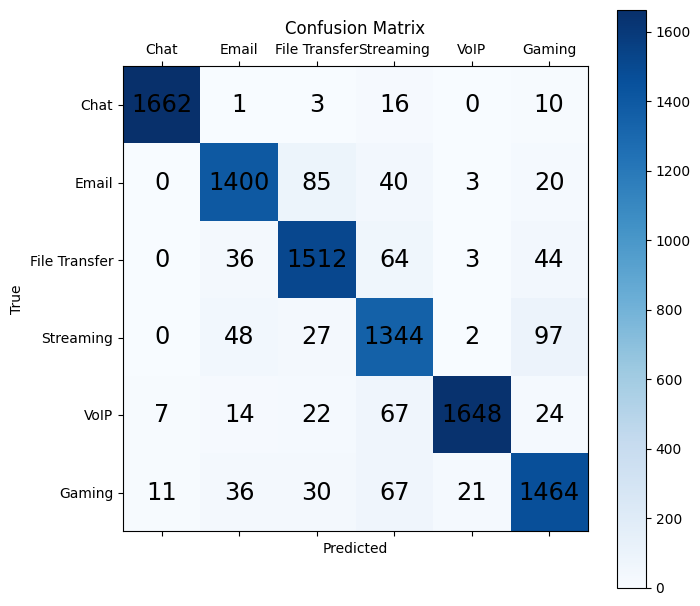

               precision    recall  f1-score   support

         Chat     0.9823    0.9893    0.9858      1680
        Email     0.9044    0.9121    0.9082      1535
File Transfer     0.9114    0.9005    0.9059      1679
    Streaming     0.8854    0.8411    0.8626      1598
         VoIP     0.9248    0.9827    0.9529      1677
       Gaming     0.8987    0.8825    0.8905      1659

     accuracy                         0.9188      9828
    macro avg     0.9178    0.9180    0.9177      9828
 weighted avg     0.9183    0.9188    0.9183      9828



In [7]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# Confusion matrix 
plot_cm(y_test, y_pred)

# Classification report
print(classification_report(y_test, y_pred, digits=4, target_names=label_dict.values()))

# Store Results
results_dictionary["RandomForest"] = [accuracy_score(y_test, y_pred), precision_score(y_test, y_pred, average="weighted"), recall_score(y_test, y_pred, average="weighted"), f1_score(y_test, y_pred, average="weighted")]

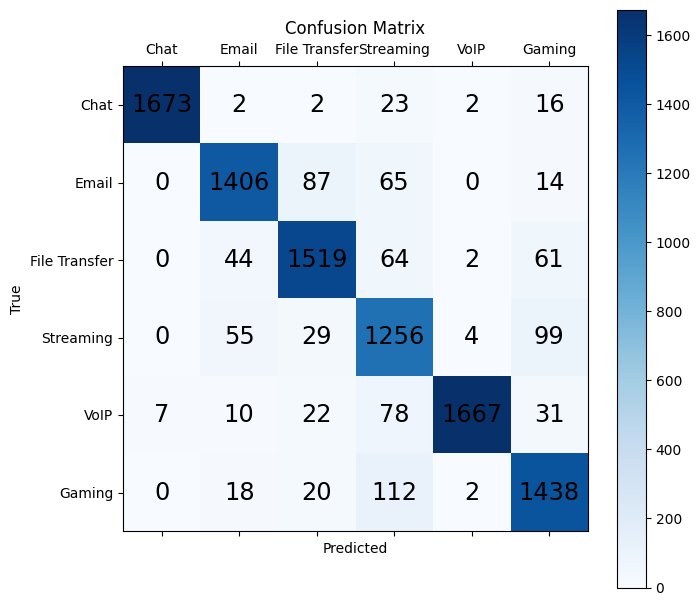

              precision    recall  f1-score   support

           0     0.9958    0.9738    0.9847      1718
           1     0.9160    0.8944    0.9051      1572
           2     0.9047    0.8988    0.9018      1690
           3     0.7860    0.8704    0.8260      1443
           4     0.9940    0.9185    0.9548      1815
           5     0.8668    0.9044    0.8852      1590

    accuracy                         0.9116      9828
   macro avg     0.9106    0.9100    0.9096      9828
weighted avg     0.9154    0.9116    0.9128      9828



In [8]:
decision_tree_clf = DecisionTreeClassifier(random_state=42)
decision_tree_clf.fit(X_train, y_train)
y_pred = decision_tree_clf.predict(X_test)

# Confusion matrix 
plot_cm(y_test, y_pred)

# Classification report
print(classification_report(y_pred, y_test, digits=4))

# Store results
results_dictionary["DecisionTree"] =  [accuracy_score(y_test, y_pred), precision_score(y_test, y_pred, average="weighted"), recall_score(y_test, y_pred, average="weighted"), f1_score(y_test, y_pred, average="weighted")]

C:\Users\Wai Qun\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


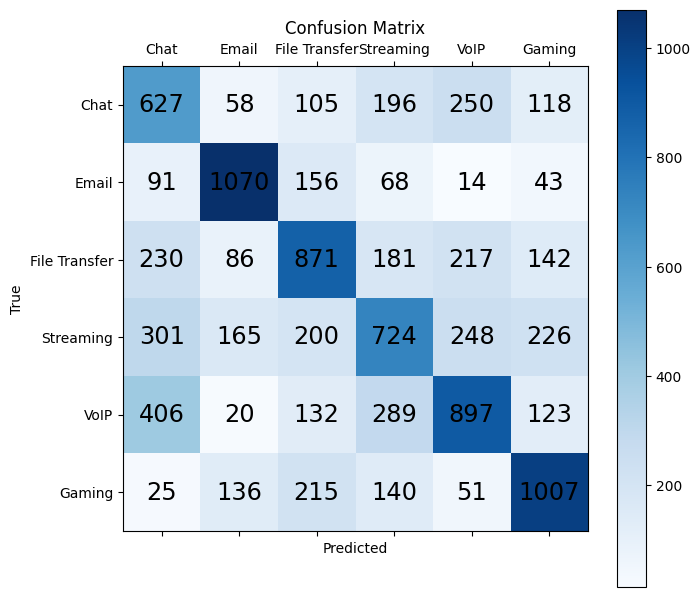

              precision    recall  f1-score   support

           0     0.3732    0.4631    0.4133      1354
           1     0.6971    0.7420    0.7188      1442
           2     0.5188    0.5043    0.5115      1727
           3     0.4531    0.3884    0.4183      1864
           4     0.5349    0.4804    0.5062      1867
           5     0.6070    0.6398    0.6230      1574

    accuracy                         0.5287      9828
   macro avg     0.5307    0.5363    0.5318      9828
weighted avg     0.5296    0.5287    0.5275      9828



In [9]:
base_estimator = DecisionTreeClassifier(max_depth=1)
adaboost_clf = AdaBoostClassifier(base_estimator=base_estimator, n_estimators=50, random_state=42)
adaboost_clf.fit(X_train, y_train)
y_pred = adaboost_clf.predict(X_test)

# Confusion matrix 
plot_cm(y_test, y_pred)

# Classification report
print(classification_report(y_pred, y_test, digits=4))

# Store results
results_dictionary["AdaBoost"] =  [accuracy_score(y_test, y_pred), precision_score(y_test, y_pred, average="weighted"), recall_score(y_test, y_pred, average="weighted"), f1_score(y_test, y_pred, average="weighted")]

C:\Users\Wai Qun\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


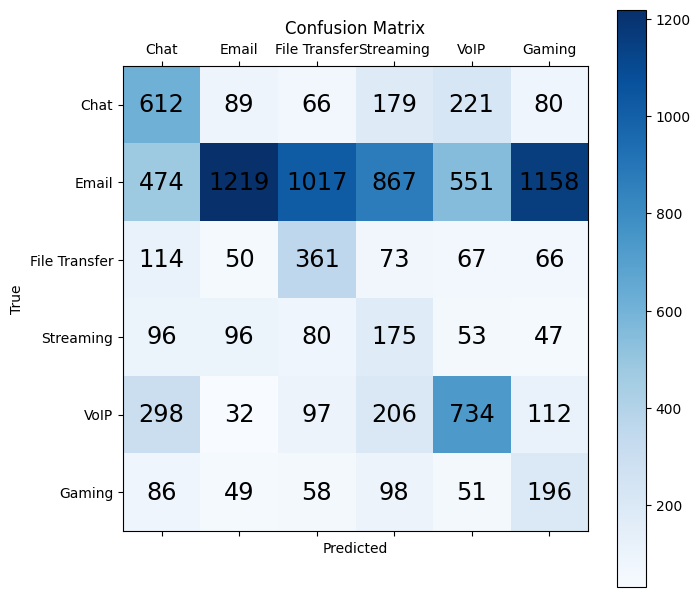

              precision    recall  f1-score   support

           0     0.3643    0.4908    0.4182      1247
           1     0.7941    0.2306    0.3574      5286
           2     0.2150    0.4938    0.2996       731
           3     0.1095    0.3199    0.1632       547
           4     0.4377    0.4963    0.4651      1479
           5     0.1181    0.3643    0.1784       538

    accuracy                         0.3355      9828
   macro avg     0.3398    0.3993    0.3137      9828
weighted avg     0.5678    0.3355    0.3564      9828



In [10]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

# Confusion matrix 
plot_cm(y_test, y_pred)

# Classification report
print(classification_report(y_pred, y_test, digits=4))

# Store results
results_dictionary["LogisticRegression"] =  [accuracy_score(y_test, y_pred), precision_score(y_test, y_pred, average="weighted"), recall_score(y_test, y_pred, average="weighted"), f1_score(y_test, y_pred, average="weighted")]

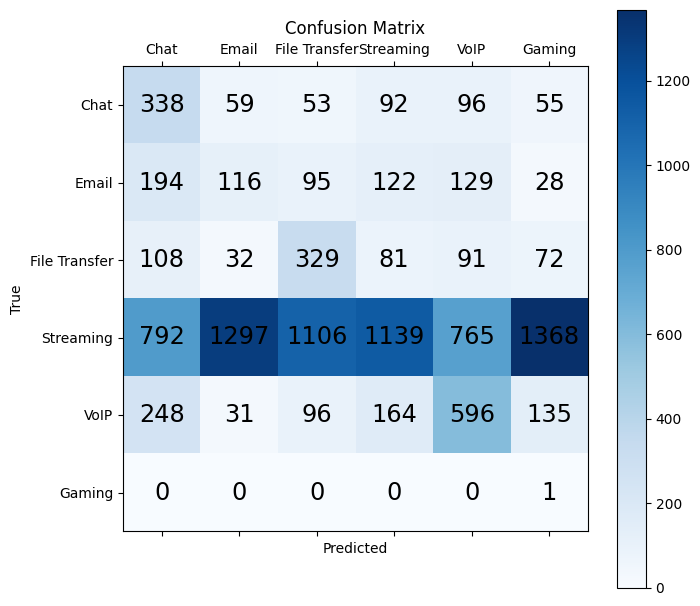

              precision    recall  f1-score   support

           0     0.2012    0.4877    0.2849       693
           1     0.0756    0.1696    0.1046       684
           2     0.1959    0.4614    0.2751       713
           3     0.7128    0.1761    0.2825      6467
           4     0.3554    0.4693    0.4045      1270
           5     0.0006    1.0000    0.0012         1

    accuracy                         0.2563      9828
   macro avg     0.2569    0.4607    0.2254      9828
weighted avg     0.5486    0.2563    0.2854      9828



In [11]:
nb_clf = MultinomialNB()
nb_clf.fit(X_train, y_train)
y_pred = nb_clf.predict(X_test)

# Confusion matrix 
plot_cm(y_test, y_pred)

# Classification report
print(classification_report(y_pred, y_test, digits=4))

# Store results
results_dictionary["MultinomialNB"] =  [accuracy_score(y_test, y_pred), precision_score(y_test, y_pred, average="weighted"), recall_score(y_test, y_pred, average="weighted"), f1_score(y_test, y_pred, average="weighted")]

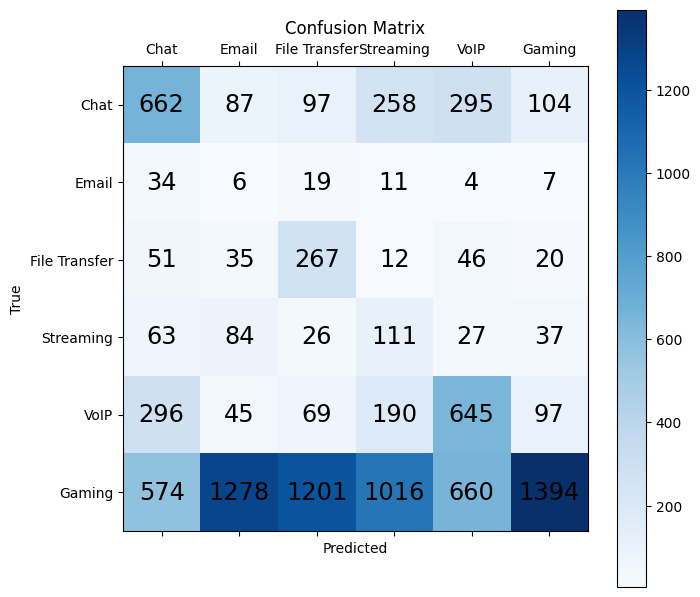

              precision    recall  f1-score   support

           0     0.3940    0.4405    0.4160      1503
           1     0.0039    0.0741    0.0074        81
           2     0.1590    0.6195    0.2531       431
           3     0.0695    0.3190    0.1141       348
           4     0.3846    0.4806    0.4273      1342
           5     0.8403    0.2277    0.3583      6123

    accuracy                         0.3139      9828
   macro avg     0.3086    0.3602    0.2627      9828
weighted avg     0.6457    0.3139    0.3604      9828



In [12]:
svm_clf = SVC(gamma = 'auto')
svm_clf.fit(X_train, y_train)
y_pred = svm_clf.predict(X_test)

# Confusion matrix 
plot_cm(y_test, y_pred)

# Classification report
print(classification_report(y_pred, y_test, digits=4))

# Store results
results_dictionary["SVM"] =  [accuracy_score(y_test, y_pred), precision_score(y_test, y_pred, average="weighted"), recall_score(y_test, y_pred, average="weighted"), f1_score(y_test, y_pred, average="weighted")]

In [13]:
result_df = pd.DataFrame(results_dictionary, index=['accuracy', 'precision', 'recall', 'f1'])
result_df = result_df.T
result_df

,accuracy,precision,recall,f1
CNN,0.736060,0.745591,0.736060,0.735153
RandomForest,0.918803,0.918332,0.918803,0.918303
DecisionTree,0.911579,0.910621,0.911579,0.910385
AdaBoost,0.528694,0.534345,0.528694,0.529841
LogisticRegression,0.335470,0.402478,0.335470,0.314508
MultinomialNB,0.256309,0.466209,0.256309,0.227168
SVM,0.313899,0.364998,0.313899,0.267436
